## Additional import for adding package path for iCSF

## Import packages

In [39]:
#import the models and plotting tools

import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import PseudoVoigtModel  ##error: No module named 'lmfit'
from lmfit.parameter import Parameters
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
from scipy.signal import medfilt
from matplotlib.pyplot import close
import imageio
import glob, os
import ipywidgets as widgets
from ipywidgets import fixed

import time
import pickle

#import diamond_functions as dia
from diamond_functions import *
from Analysis_and_plot_functions import *

#for graphs inline with the text on mac and widows...
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for interactive graphs inline with the text on mac and widows...
#%matplotlib interactive
#best for pop-out graphs on windows...
#%matplotlib tk
#best for pop-out graphs on mac...
# %matplotlib
#for pop-out graphs on mac and windows, but it's a bit dodgey...
#%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Adjusting plot parameters

In [2]:
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Define directory & fileprefix for two theta & intensity data:

Load in Engineering stress strain data

Text(0.5, 0, 'Strain, ${\\epsilon}$')

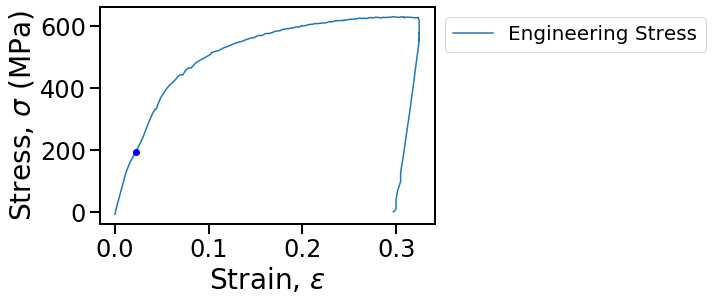

In [9]:
##Sample2
##dir_prefix = '../../Dropbox (The University of Manchester)/2. Project/Python Script/Single Peak Fitting Script ORIGINAL - Copy'

##Sample3
dir_prefix = r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy'

Eng_stress = np.loadtxt(dir_prefix + '\\Force_Strain_Sample3.txt', usecols=0)
Eng_stress = Eng_stress*10**3/(1.12*3.22)
Eng_strain = np.loadtxt(dir_prefix + '\\Force_Strain_Sample3.txt', usecols=1)
plt.plot(Eng_strain, Eng_stress, label = 'Engineering Stress')
plt.plot(Eng_strain[10], Eng_stress[10], 'bo')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=28)
plt.xlabel('Strain, ${\epsilon}$', fontsize=28)

# Ensure input and ouput directories are correct

In [11]:
dirname=dir_prefix + '\Sample3\\'
filePrefix = 'Strain_'
fname=filePrefix+'00000.dat'
open_z_file=str(dirname+fname)
dir_FitResults=dir_prefix + '\Looped Fit Results\\'

output_dir = dir_prefix + '\S3_Out_plots\\'

print('dirname: ' + dirname)
print('filePrefix: ' + filePrefix)

print('combined: ' + open_z_file)

print(output_dir)

dirname: C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Sample3\
filePrefix: Strain_
combined: C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Sample3\Strain_00000.dat
C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\S3_Out_plots\


# Location of delta and gamma peaks can also be added

In [12]:
crystal_dir = r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Crystallographic data files\Crystalographic Data'

HCP_reflections_file = crystal_dir + '\HCP_twotheta.txt' # This would be better named 'HCP_ttheta_file' 
HCP_reflection_names = crystal_dir + '\HCP_reflection_names.txt'
FCC_reflections_file = crystal_dir + '\FCC_twotheta.txt' # This would be better named 'FCC_ttheta_file' 
FCC_reflection_names = crystal_dir + '\FCC_reflection_names.txt'
FCT_ttheta_file = crystal_dir + '\FCT_twotheta.txt'
FCT_reflection_names = crystal_dir + '\FCT_reflection_names.txt'

HCP_twotheta = list(np.loadtxt(HCP_reflections_file))
HCP_reflections = list(np.loadtxt(HCP_reflection_names, delimiter='\t', skiprows = 1))
FCC_twotheta = list(np.loadtxt(FCC_reflections_file))
FCC_reflections = list(np.loadtxt(FCC_reflection_names, skiprows = 1))
FCT_twotheta = list(np.loadtxt(FCT_ttheta_file))
FCT_reflections = list(np.loadtxt(FCT_reflection_names, skiprows = 1))

HCP_reflections_formated = []
FCC_reflections_formated = []
FCT_reflections_formated = []

#print(HCP_reflections)

for i in HCP_reflections:
    i = ['%.0f' % elem for elem in i]
    i = ' '.join(map(str,i))
    i = i.strip('[')
    i = i.strip(']')
    i = i.strip(' ')
    i = '(' + i + ')'
    
    HCP_reflections_formated.append(i)
    
for i in FCC_reflections:
    i = ['%.0f' % elem for elem in i]
    i = ' '.join(map(str,i))
    i = i.strip('[')
    i = i.strip(']')
    i = i.strip(' ')
    i = '(' + i + ')'
    
    FCC_reflections_formated.append(i)
    
for i in FCT_reflections:
    i = ['%.0f' % elem for elem in i]
    i = ' '.join(map(str,i))
    i = i.strip('[')
    i = i.strip(']')
    i = i.strip(' ')
    i = '(' + i + ')'
    
    FCT_reflections_formated.append(i)
    
HCP = list(zip(HCP_reflections_formated, HCP_twotheta))
FCC = list(zip(FCC_reflections_formated, FCC_twotheta))
FCT = list(zip(FCT_reflections_formated, FCT_twotheta))
    
'''print('HCP Reflection and twotheta: {0}'.format(HCP), '\n\n FCC Reflections and twotheta: {0}'.format(FCC), 
      '\n\n FCT Reflections and twotheta: {0}'.format(FCT))'''

"print('HCP Reflection and twotheta: {0}'.format(HCP), '\n\n FCC Reflections and twotheta: {0}'.format(FCC), \n      '\n\n FCT Reflections and twotheta: {0}'.format(FCT))"

## Fit overlapping peaks

Create a Fit2Peak instance (different class for fitting overlapping peaks):

In [13]:
images = []

for i in range(1, 37): 
    image=Fit2Peak(dirname,fname,cake=i)
    images.append(image)
    
    
images[0].spectrum

array([[ 1.29015, 72.4858 ],
       [ 1.29522, 74.0363 ],
       [ 1.3003 , 80.6806 ],
       ...,
       [11.4234 , 33.8759 ],
       [11.4285 , 32.8189 ],
       [11.4336 , 32.2199 ]])

Use the spectrum in the object and the plot_spectrum function to plot the selected regions of interest in spectrum:

C:\Users\mbgnwob2\GitHub\Peak-Fit\diamond_functions.py:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


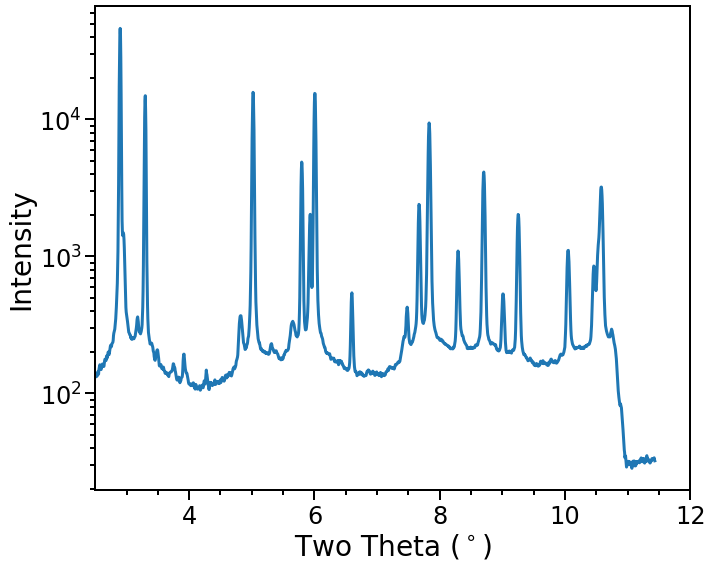

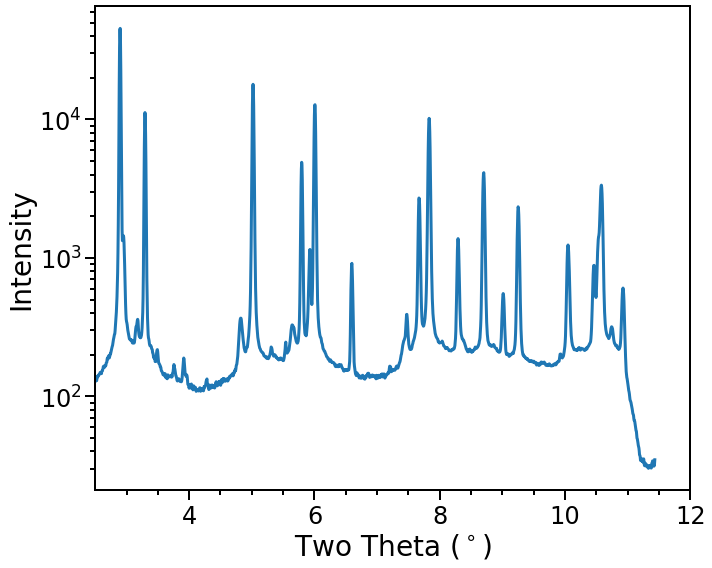

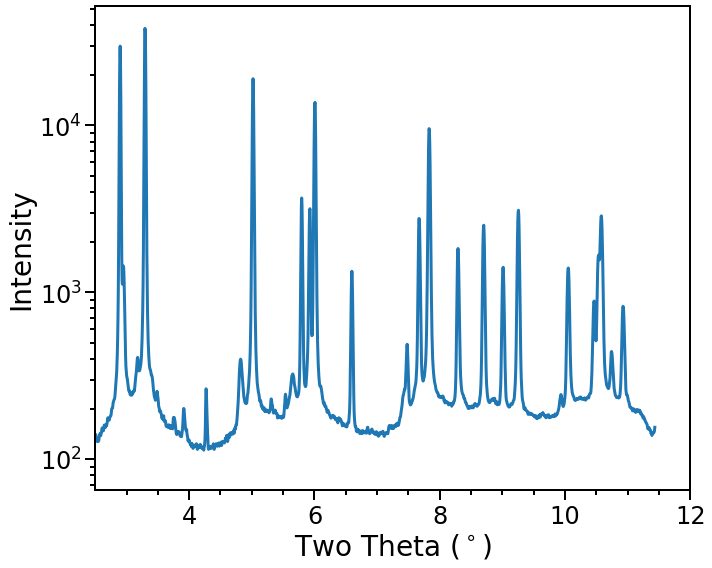

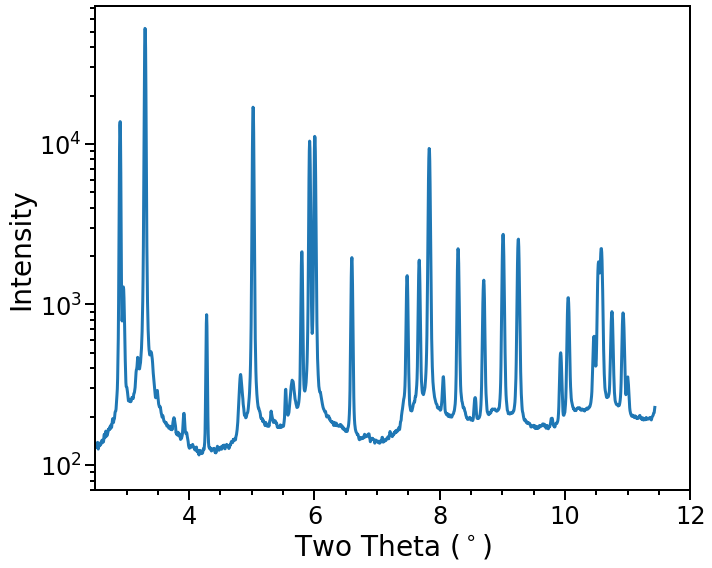

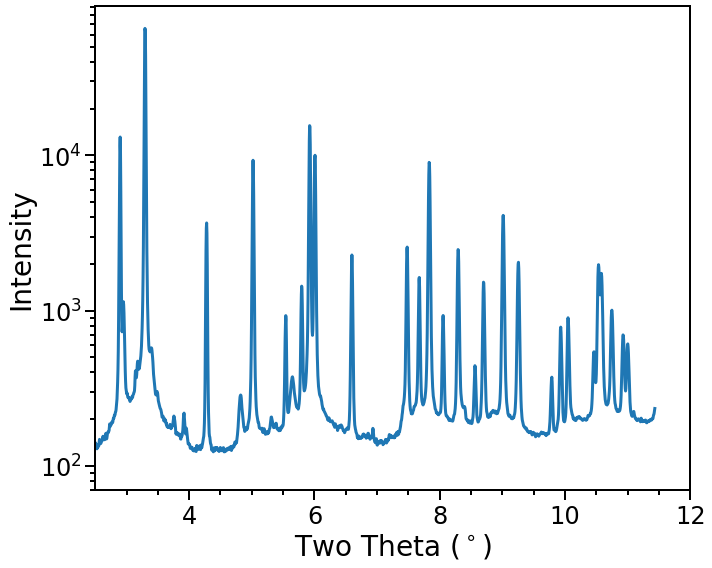

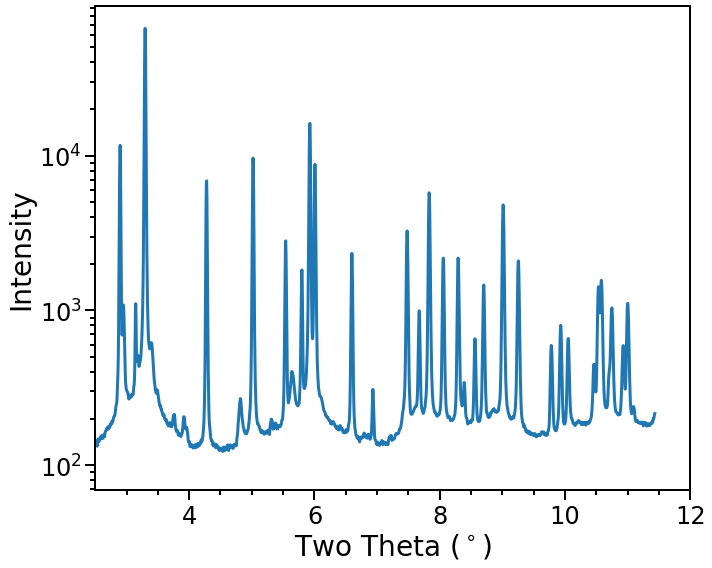

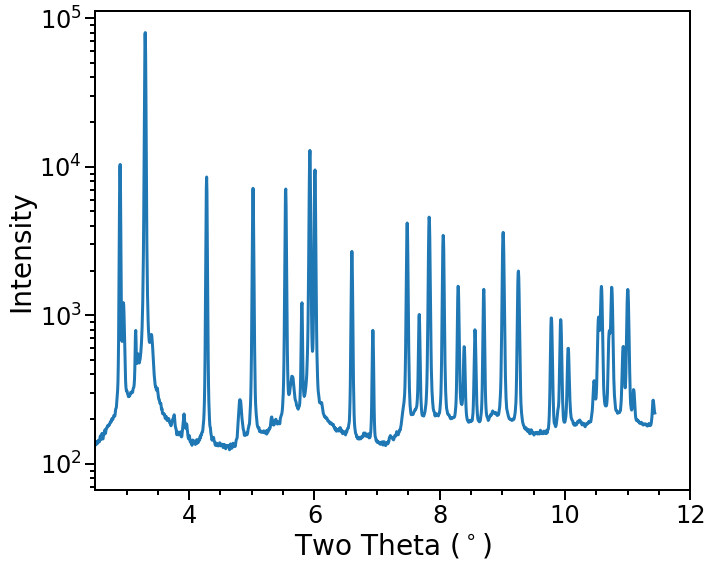

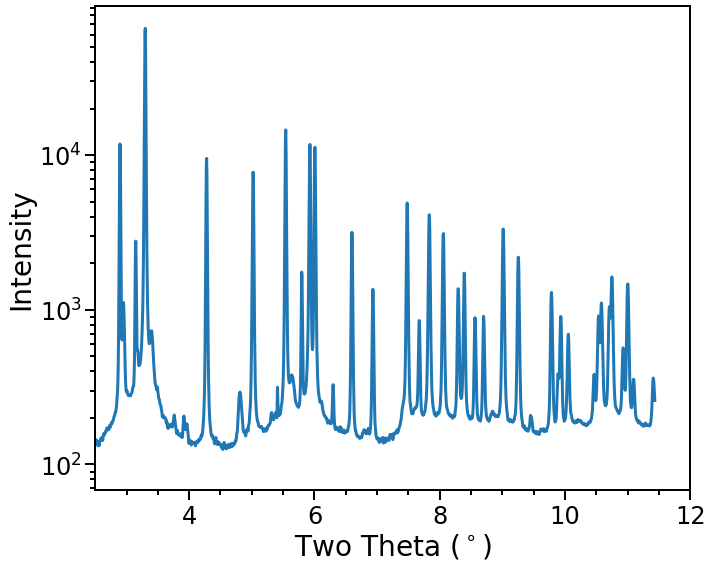

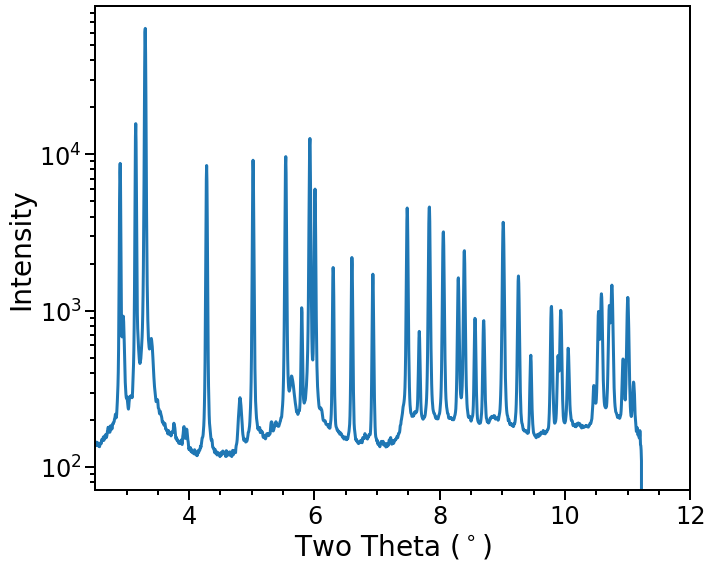

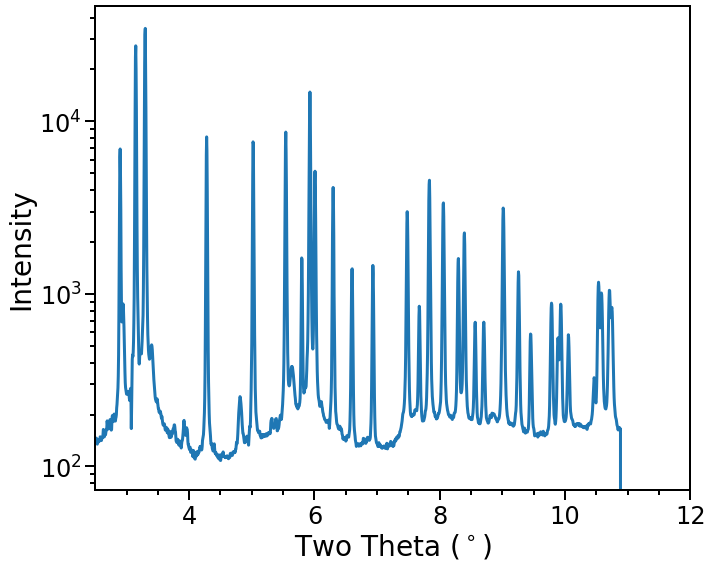

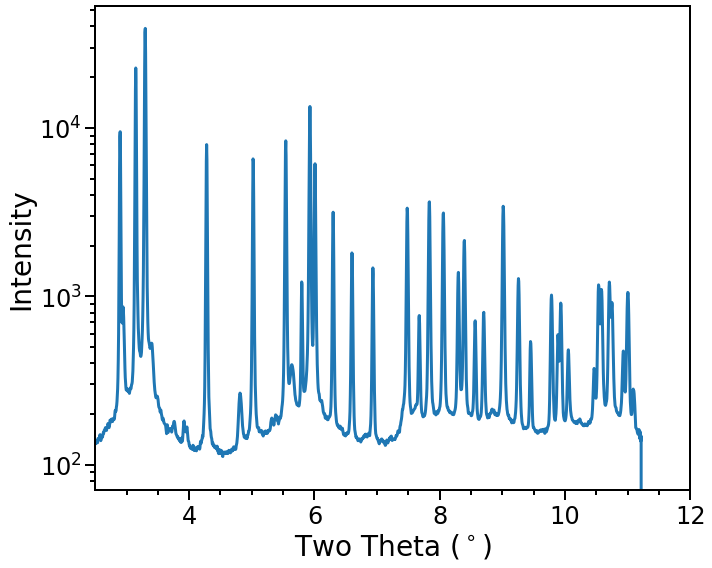

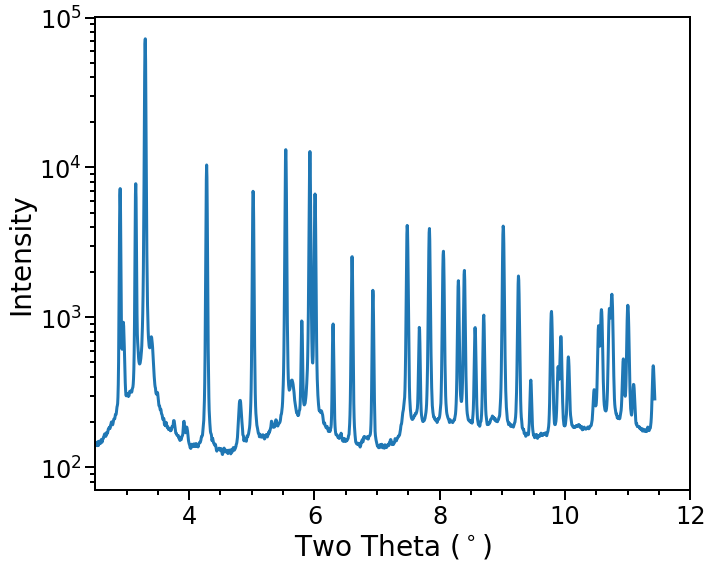

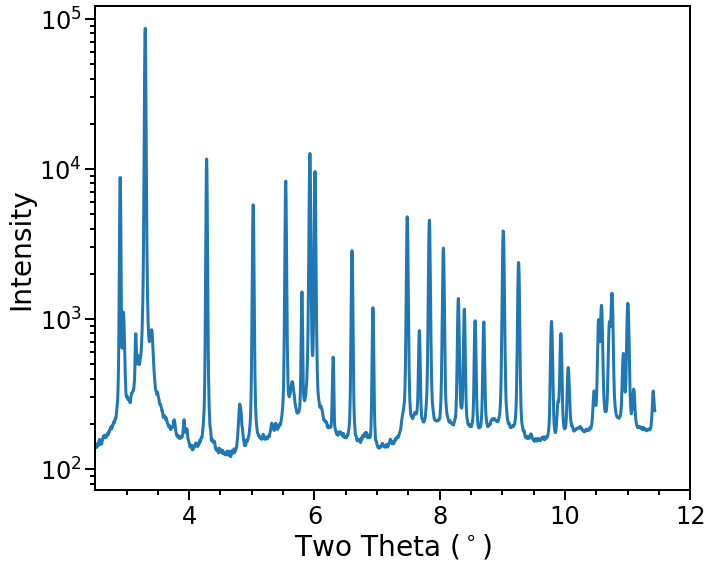

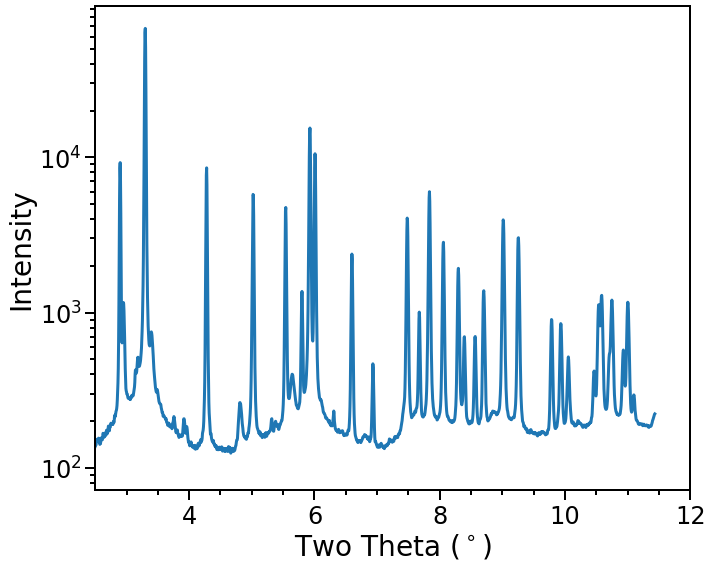

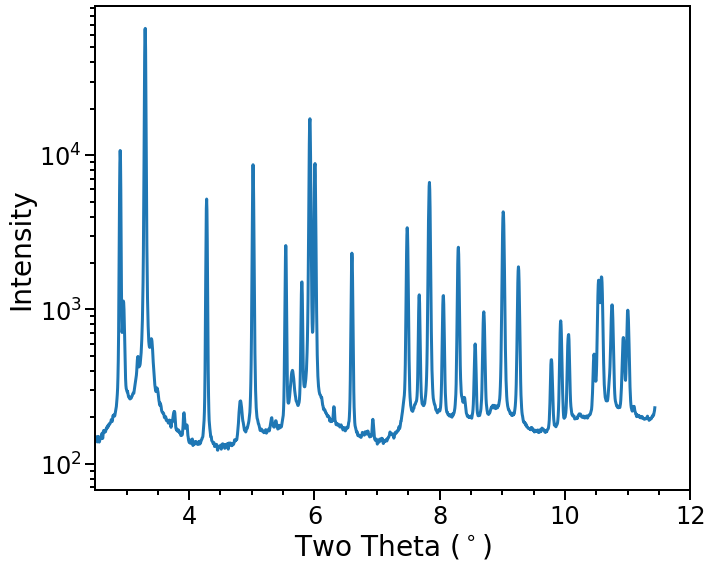

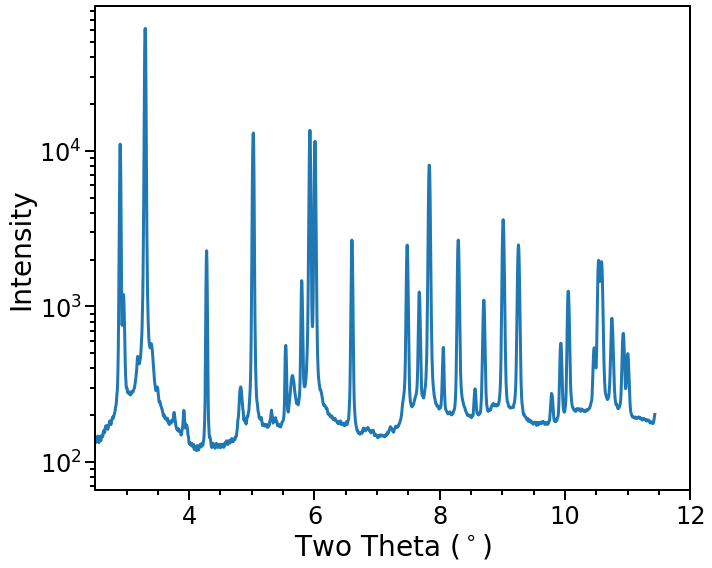

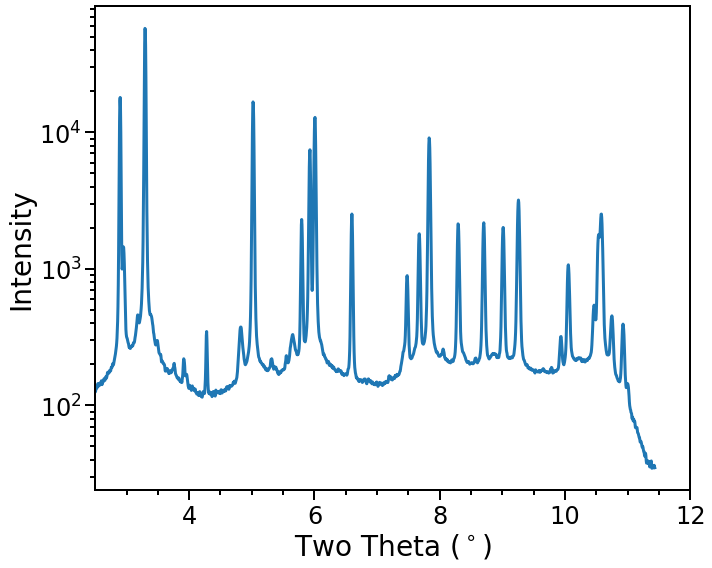

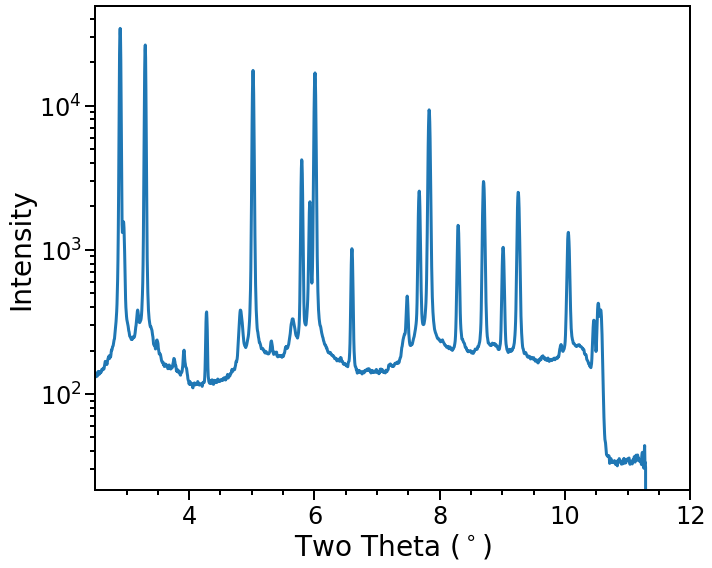

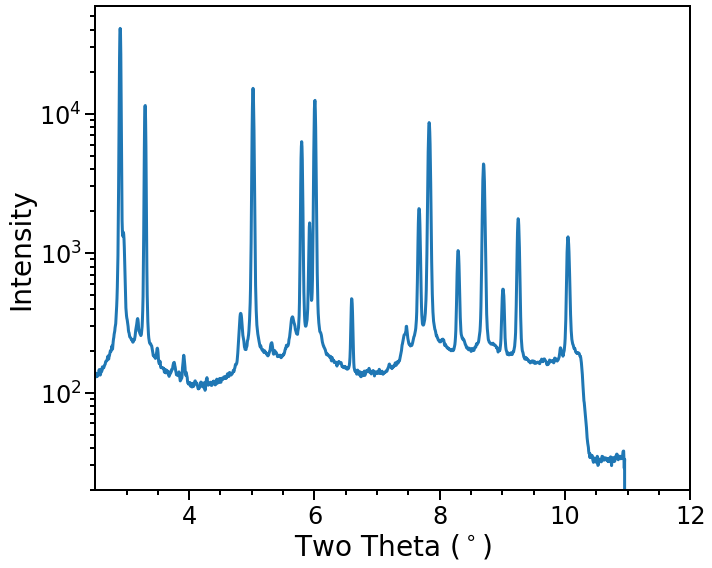

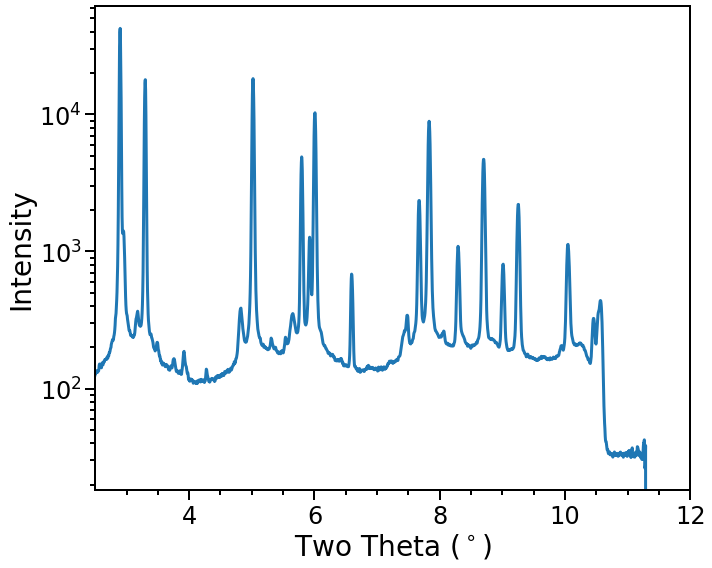

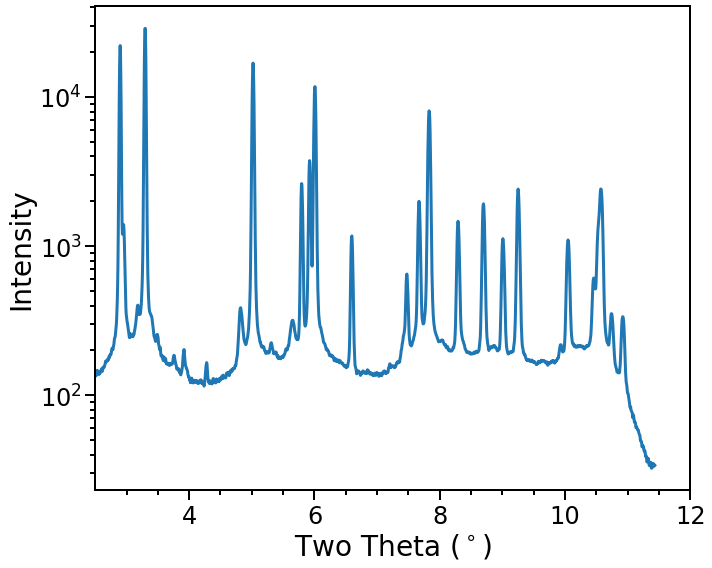

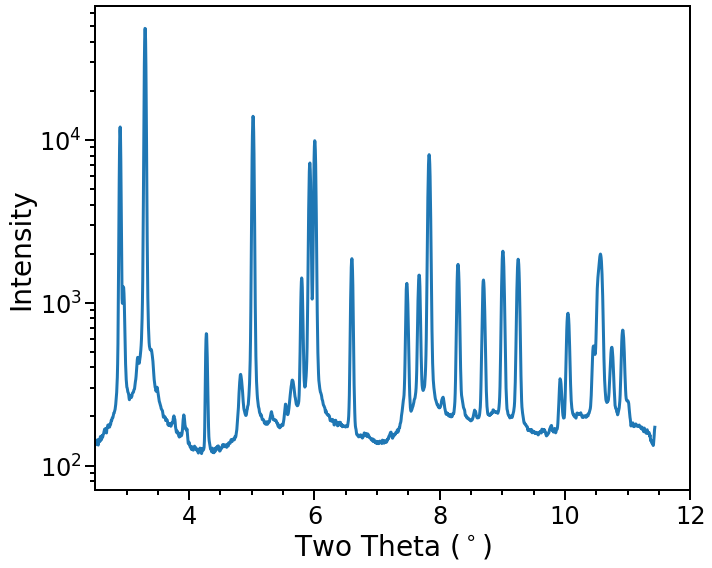

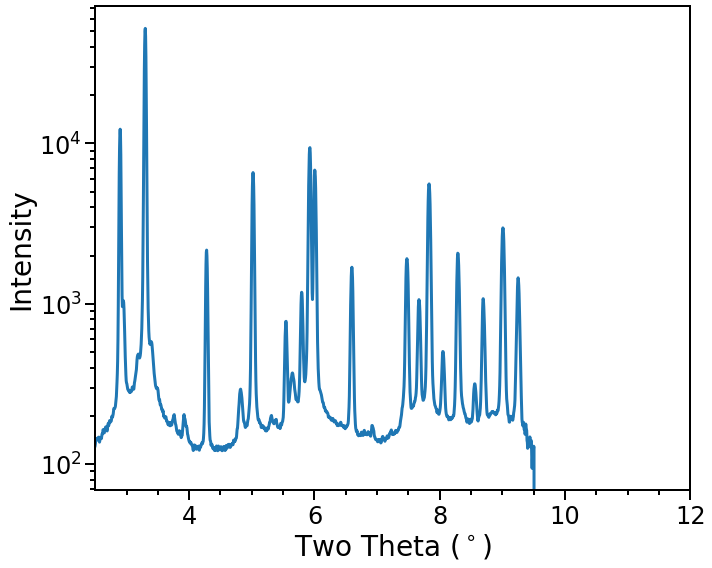

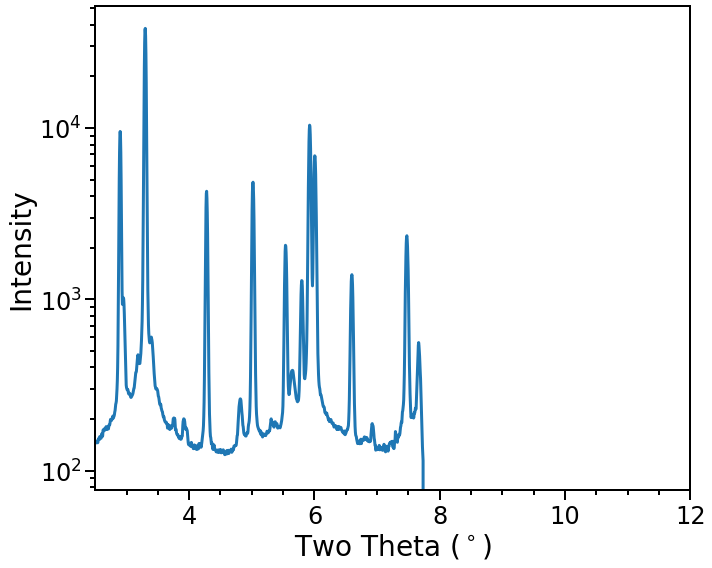

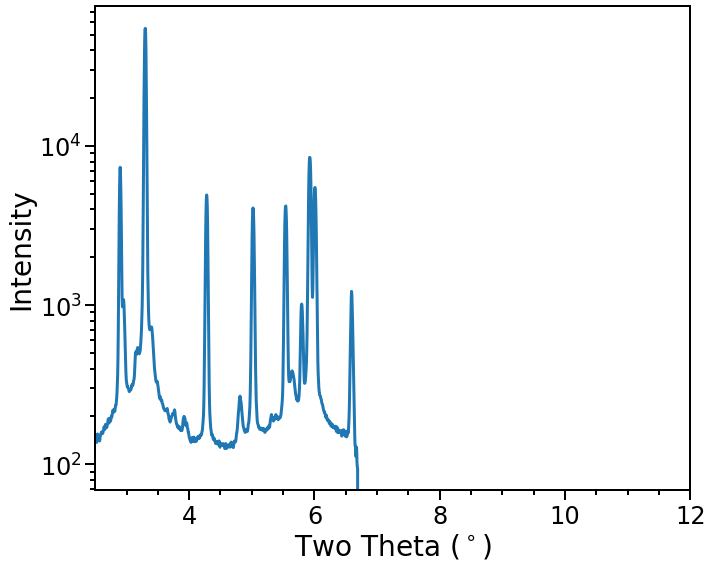

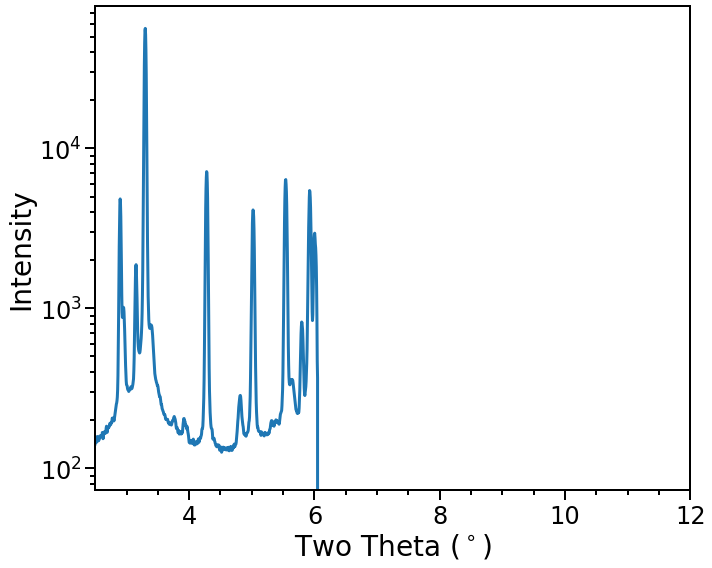

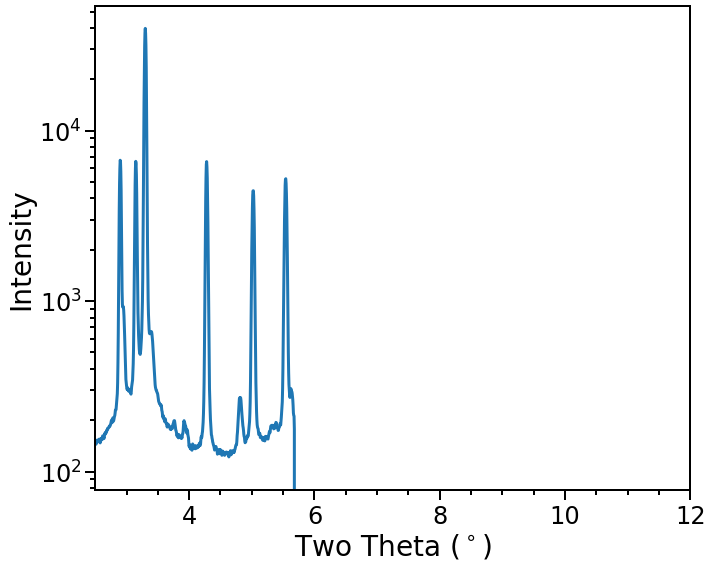

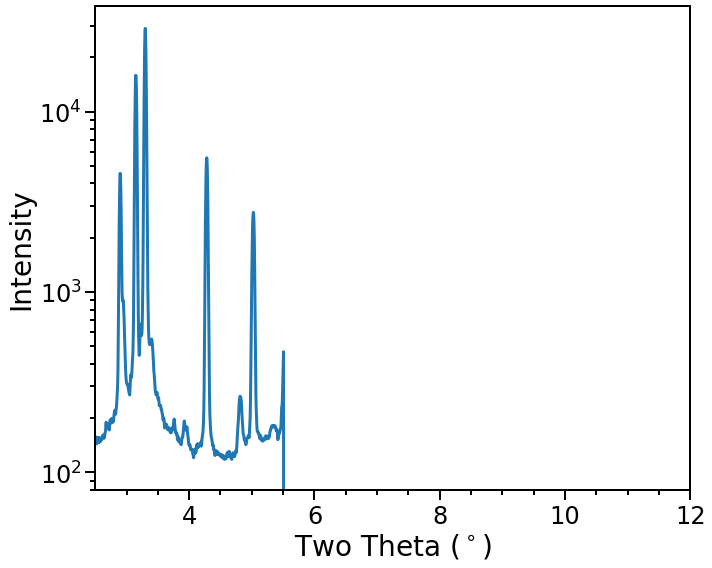

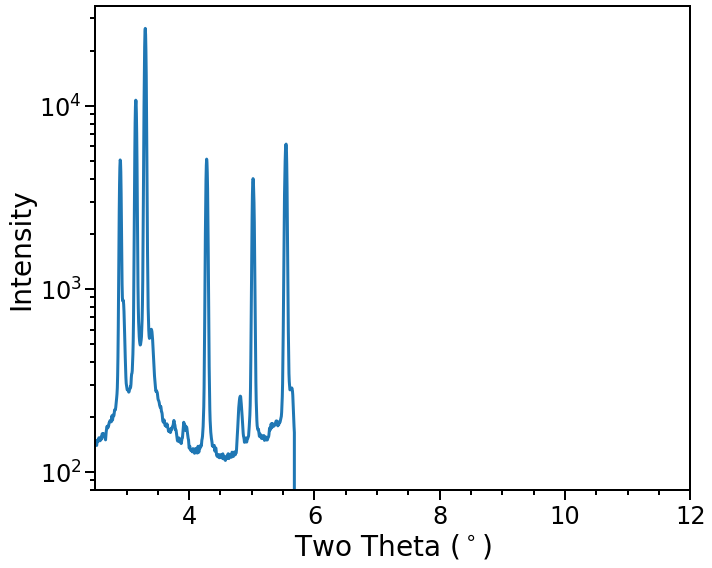

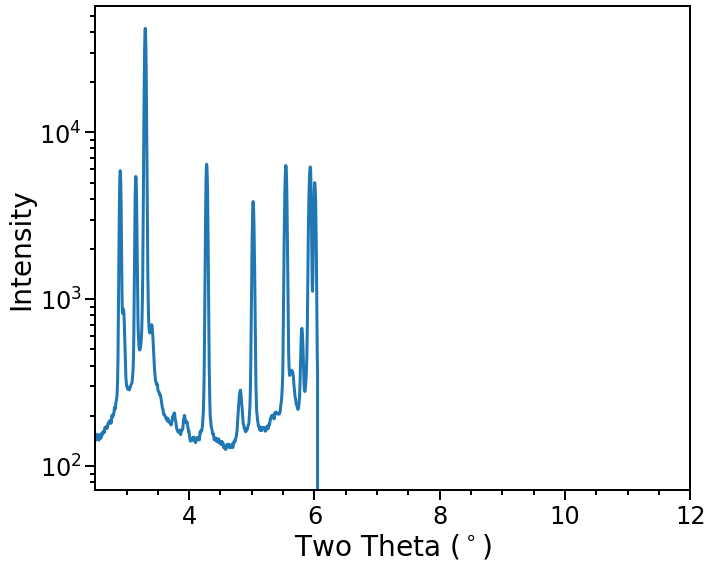

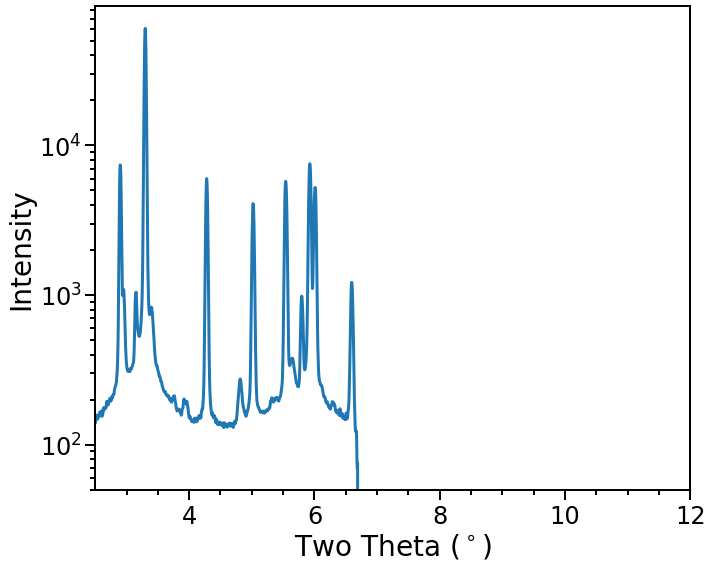

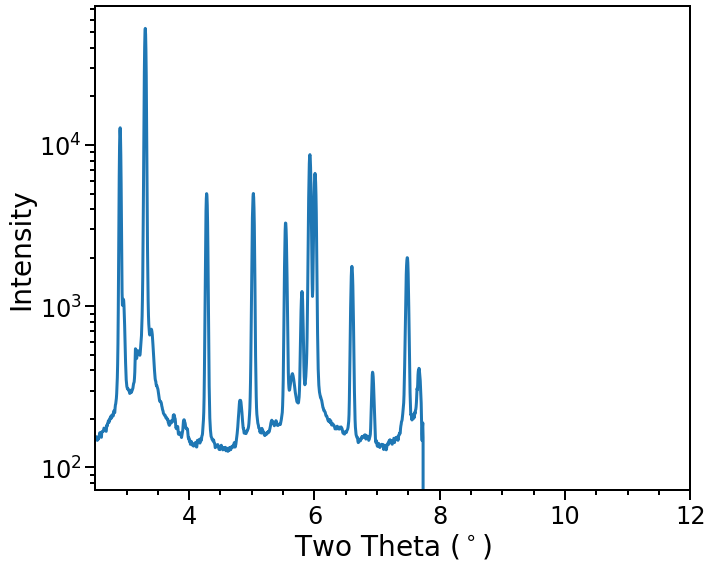

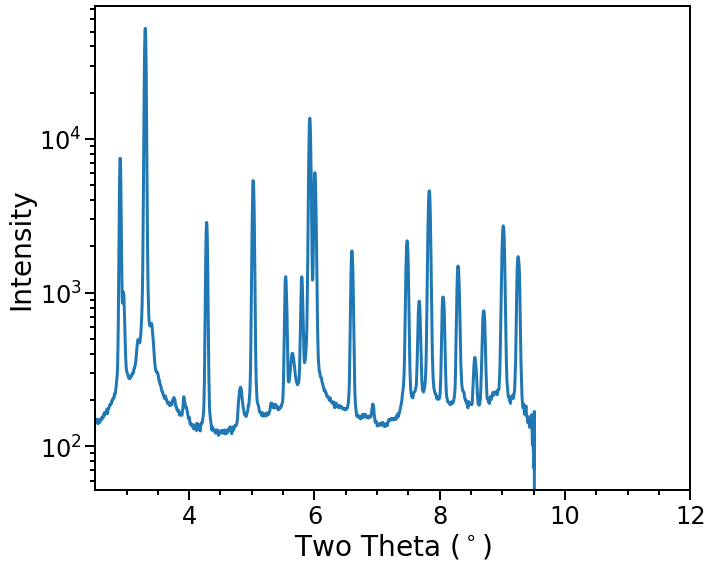

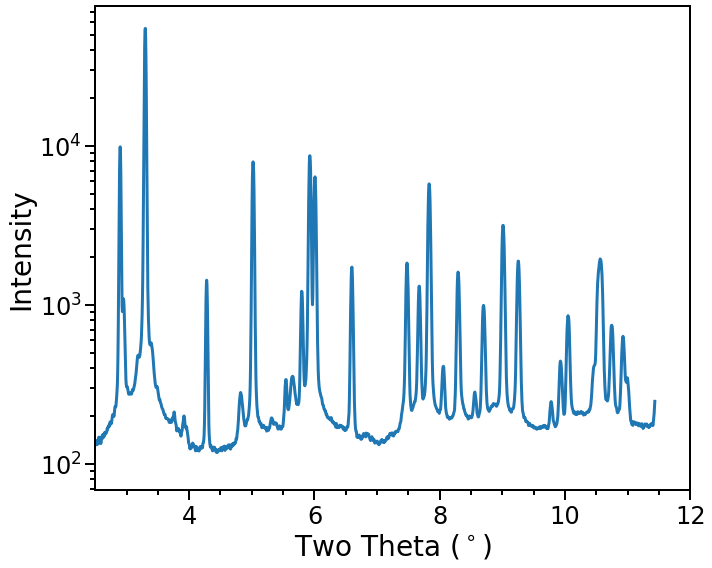

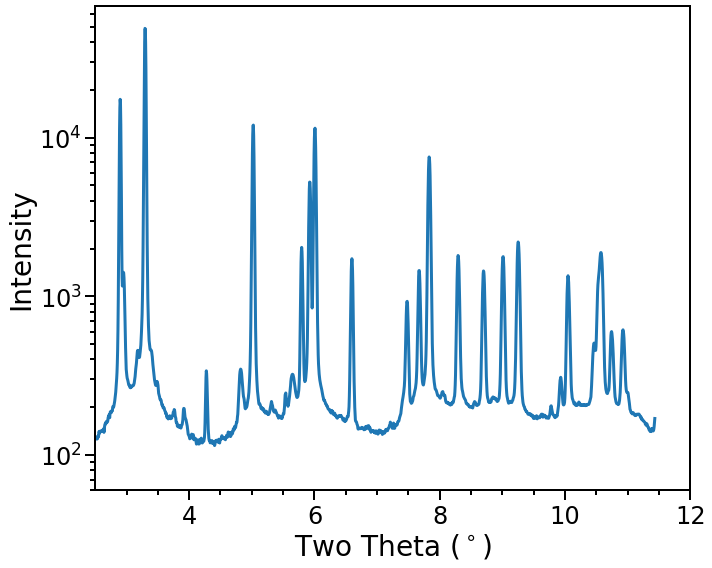

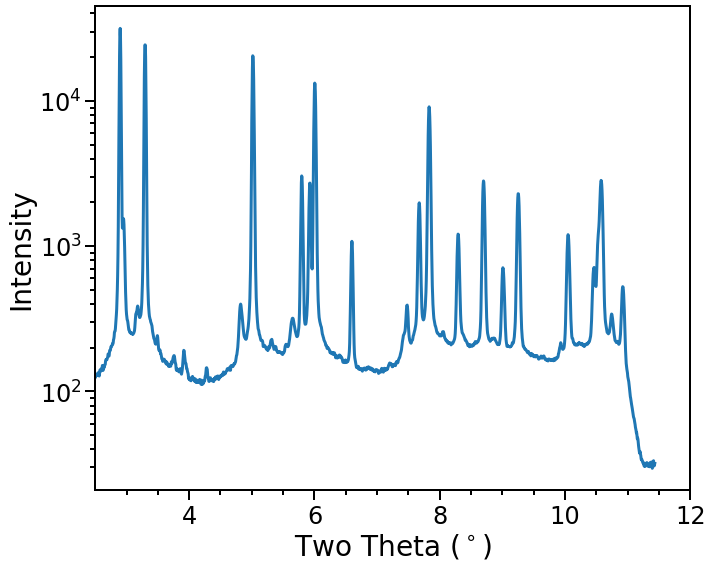

In [14]:
for i in images: 
    plot_spectrum(i, xmin=2.5, xmax=12)

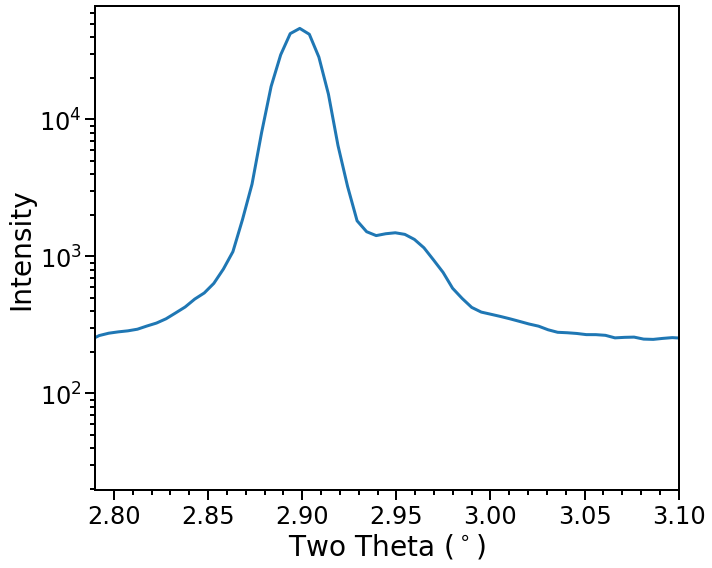

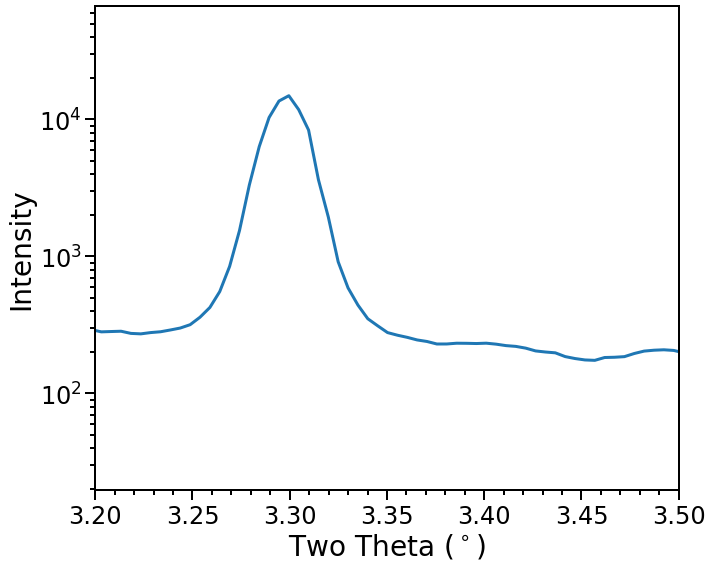

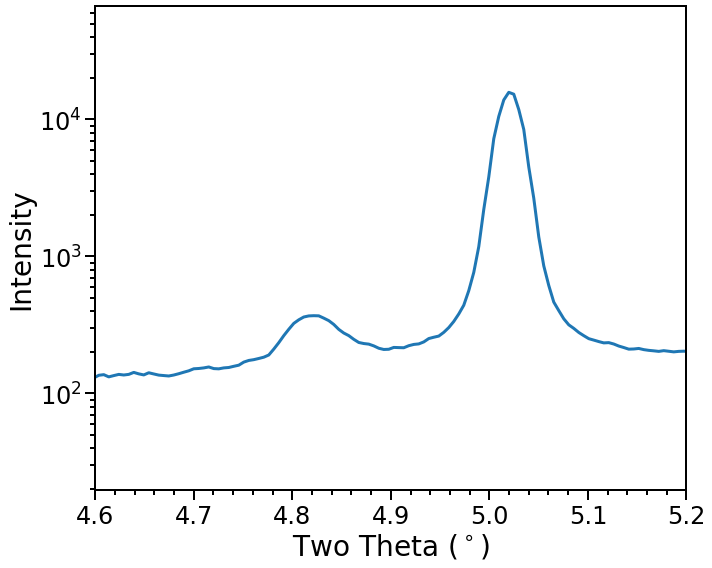

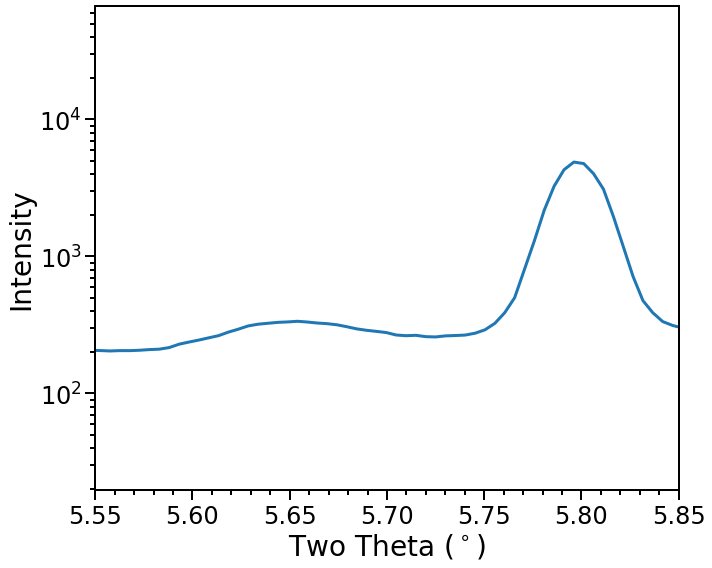

In [15]:
plot_spectrum(images[0], xmin=2.79, xmax=3.1) # (01-10) & (111)
plot_spectrum(images[0], xmin=3.2, xmax=3.5) # (01-11) & (200)
plot_spectrum(images[0], xmin=4.6, xmax=5.2) # (220) & (11-20)
plot_spectrum(images[0], xmin=5.55, xmax=5.85) # (311) & (02-20)


#plot_spectrum(image_1, xmin=3.7, xmax=3.83) # (210) 
#plot_spectrum(image_1, xmin=4.2, xmax=4.4) # (01-12)

#plot_spectrum(image_1, xmin=5.5, xmax=5.7) # (01-13) & (311)


#image_1.plot_spectrum(6.2, 6.8) # (02-22)
#image_1.plot_spectrum(7.2, 8.1) # (02-23) & (21-30) & (21-31)
#image_1.plot_spectrum(8.1, 9.5) # (21-31) & (03-30) & (21-33) & (03-32)

# Fit two overlapping peaks

Define peak bounds (in this case covering the 2 overlapping peaks for the entire thermo-mechanical cycle) and labels of the overlapping peaks as a single string:

In [16]:
sdy_pks = '(220) & (11-20)'
peak_bounds_initial = [(4.55, 5.22)] 
peak_labels_initial = [sdy_pks]
#starting centres for the function fit_two_peaks are 

#note, min and max values are not the same as bounds around the peak, but values that they can go up to! 

pv_1_cent=4.81
pv_1_min=4.72
pv_1_max=4.88


pv_2_cent=5.02
pv_2_min=4.91
pv_2_max=5.2


pv_1_cent, pv_1_min, pv_1_max, pv_2_cent, pv_2_min, pv_2_max

(4.81, 4.72, 4.88, 5.02, 4.91, 5.2)

The method `fit_2_peaks` fits two overlapping peaks:

In [17]:
images[0].fit_2_peaks(peak_labels_initial, peak_bounds_initial, 
                    pv_1_cent, pv_1_min, pv_1_max,
                    pv_2_cent, pv_2_min, pv_2_max)

Results for the fit to both peaks can be looked up:

In [18]:
images[0].fits_dict[sdy_pks].values

{'pv_1amplitude': 13.957015024879798,
 'pv_1center': 4.8229016241668425,
 'pv_1sigma': 0.03155475156710136,
 'pv_1fraction': 0.08789336110197166,
 'pv_1fwhm': 0.06310950313420272,
 'pv_1height': 201.8755429208186,
 'pv_2amplitude': 529.7000204137406,
 'pv_2center': 5.0206326856206545,
 'pv_2sigma': 0.014447899117766167,
 'pv_2fraction': 0.256889286865119,
 'pv_2fwhm': 0.028895798235532334,
 'pv_2height': 15795.178030550358,
 'constBG': 152.28117277361233}

Now, the peak centre of each peak is additionally labelled pv_1 and pv_2:

In [19]:
print('peak centres...')
print(images[0].fits_dict[sdy_pks].values['pv_1center'])
print(images[0].fits_dict[sdy_pks].values['pv_2center'])

print('peak sigmas...')
print(images[0].fits_dict[sdy_pks].values['pv_1sigma'])
print(images[0].fits_dict[sdy_pks].values['pv_2sigma'])

peak centres...
4.8229016241668425
5.0206326856206545
peak sigmas...
0.03155475156710136
0.014447899117766167


The peak fit can also be plotted to check:

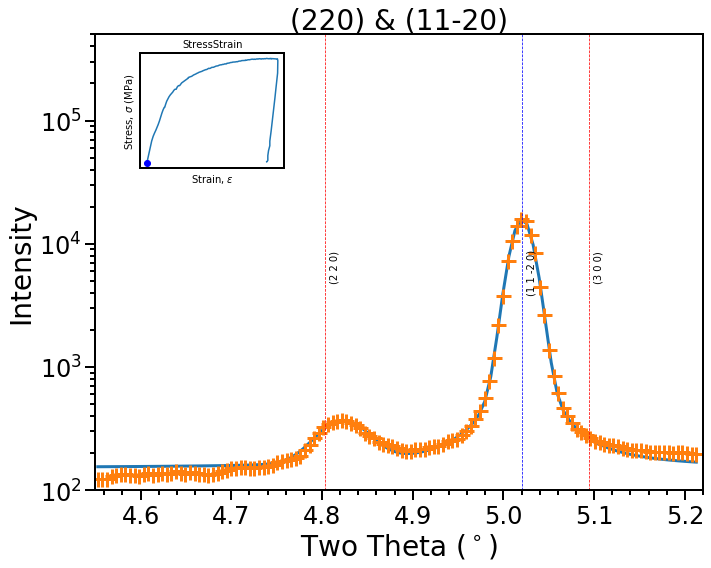

In [22]:
image_number=0
plot_fit_ss_peaks(images[0], sdy_pks, xlims = peak_bounds_initial[0], x_val=Eng_strain, y_val=Eng_stress, dot_val=image_number, 
                  HCP_twotheta_data = HCP_twotheta, HCP_reflections = HCP_reflections_formated, 
                  FCC_twotheta_data = FCC_twotheta, FCC_reflections = FCC_reflections_formated, 
                 FCT_twotheta_data = FCT_twotheta, FCT_reflections = FCT_reflections_formated)

### Run through all images with two overlapping peaks

With fitting 2 overlapping peaks, choose a two-theta range which covers the peaks over the entire test. Currrently, peak bounds aren't adjusted within the loop in this case.

The initial parameters need to be passed in this case, so that the pseudo-voigt fit correctly identifies the two peaks each time.

Fitting 2 peaks:

In [24]:
#check number of "strain images" were taken
first_image=0
last_image = os.listdir(dirname)
last_image = len(last_image)-1

In [ ]:
cake = 11

first_image=0
last_image = os.listdir(dirname)
last_image = len(last_image)-1

#Boundary conditions for '111'
sdy_pks = '(01-10) & (111)'
peak_bounds_initial = [(2.79, 3.1)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=2.9
pv_1_min=2.8
pv_1_max=2.94

pv_2_cent=2.96
pv_2_min=2.92
pv_2_max=3

#Boundary conditions for '220'
'''sdy_pks = '(220) & (11-20)'
peak_bounds_initial = [(4.6, 5.2)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=4.81
pv_1_min=4.72
pv_1_max=4.88

pv_2_cent=5.02
pv_2_min=4.91
pv_2_max=5.2'''

#Boundary conditions for '311'
'''sdy_pks = '(311) & (02-20)'
peak_bounds_initial = [(5.35, 5.85)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=5.66
pv_1_min=5.38
pv_1_max=5.73

pv_2_cent=5.8
pv_2_min=5.75
pv_2_max=5.86'''

fits=run_thru_images_initParams(filePrefix, dirname, first_image, last_image, peak_bounds_initial, peak_labels_initial,
                                        'normal','two', pv_1_cent, pv_1_min, pv_1_max, pv_2_cent, pv_2_min, pv_2_max,
                                        step=1, cake=cake)

In [ ]:
fit_number='00057'
fit_string=filePrefix+fit_number

fit=fits[fit_string]

plot_fit_ss_peaks(fit, sdy_pks, xlims = peak_bounds_initial[0], x_val=Eng_strain, y_val=Eng_stress, dot_val=image_number, 
                  HCP_twotheta_data = HCP_twotheta, HCP_reflections = HCP_reflections_formated, 
                  FCC_twotheta_data = FCC_twotheta, FCC_reflections = FCC_reflections_formated, 
                 FCT_twotheta_data = FCT_twotheta, FCT_reflections = FCT_reflections_formated)

fit.fits_dict[sdy_pks].values

In [ ]:
firstFile = first_image
lastFile = last_image
step = 1


sorted_list=[]

for image_number in range(firstFile,lastFile,step):
    
    fnumber='{:05d}'.format(image_number)
    fname=filePrefix + fnumber
    
    peak_dict={}
    
    for reflection in fit.reflection_list:
        
        peak_dict[reflection]={}
        peak_dict[reflection]['data_dict']=fits[fname].data_dict[reflection]
        peak_dict[reflection]['lines_dict']=fits[fname].lines_dict[reflection]
        peak_dict[reflection]['params_values']=fits[fname].fits_dict[reflection].values
        
    sorted_list.append(peak_dict)

In [ ]:
cake = 14
filename = dir_FitResults + 'Cake_' + str(cake) + '_' + sdy_pks + '.pickle'
print(filename)

In [ ]:
os.makedirs(os.path.dirname(filename), exist_ok=True)

with open(filename, 'wb') as handle:
    pickle.dump(sorted_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Automated code below:

In [104]:
first_image=0
last_image = os.listdir(dirname)
last_image = len(last_image)-1

'''#Boundary conditions for '111'
sdy_pks = '(01-10) & (111)'
peak_bounds_initial = [(2.79, 3.1)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=2.9
pv_1_min=2.8
pv_1_max=2.94

pv_2_cent=2.96
pv_2_min=2.9
pv_2_max=3'''

#Boundary conditions for '220'
sdy_pks = '(220) & (11-20)'
peak_bounds_initial = [(4.6, 5.2)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=4.81
pv_1_min=4.72
pv_1_max=4.88

pv_2_cent=5.02
pv_2_min=4.96
pv_2_max=5.06

#Boundary conditions for '311' two peaks
'''sdy_pks = '(311) & (02-20)'
peak_bounds_initial = [(5.35, 5.85)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=5.66
pv_1_min=5.38
pv_1_max=5.73

pv_2_cent=5.8
pv_2_min=5.75
pv_2_max=5.86'''


#Boundary conditions for '311' three peaks
'''sdy_pks = '(01-13) & (311) & (02-20)'
peak_bounds_initial = [(5.35, 5.85)] 
peak_labels_initial = [sdy_pks]

pv_1_cent=5.546
pv_1_min=5.6
pv_1_max=5.5

pv_2_cent=5.66
pv_2_min=5.38
pv_2_max=5.73

pv_3_cent=5.8
pv_3_min=5.75
pv_3_max=5.86'''

#three_pk = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
two_pk = list(range(1, 36, 1))
all_fits = []

for append, i in enumerate(two_pk): #start at 1: looping through the columns of the data file i.e. cake 0 = col 1
    fits=run_thru_images_initParams(filePrefix, dirname, first_image, last_image, peak_bounds_initial, peak_labels_initial,
                                    'normal','two', 
                                    pv_1_cent, pv_1_min, pv_1_max, 
                                    pv_2_cent, pv_2_min, pv_2_max,
                                    step=1, cake=i)
        
    all_fits.append(fits)
    
    append_num = append
    cake_num = i-1
    print(append_num, cake_num)
    fit = all_fits[append_num]['Strain_00000']
    
    '''pv_1_cent = fit.fits_dict[sdy_pks].values['pv_1center']
    pv_1_min = fit.fits_dict[sdy_pks].values['pv_1center'] - (fit.fits_dict[sdy_pks].values['pv_1sigma']*3)
    pv_1_max = fit.fits_dict[sdy_pks].values['pv_1center'] + (fit.fits_dict[sdy_pks].values['pv_1sigma']*3)
    pv_2_cent = fit.fits_dict[sdy_pks].values['pv_2center']
    pv_2_min = fit.fits_dict[sdy_pks].values['pv_2center'] - (fit.fits_dict[sdy_pks].values['pv_2sigma']*3)
    pv_2_max = fit.fits_dict[sdy_pks].values['pv_2center'] + (fit.fits_dict[sdy_pks].values['pv_2sigma']*3)'''
    '''pv_3_cent = fit.fits_dict[sdy_pks].values['pv_3center']
    pv_3_min = fit.fits_dict[sdy_pks].values['pv_3center'] - (fit.fits_dict[sdy_pks].values['pv_3sigma']*3)
    pv_3_max = fit.fits_dict[sdy_pks].values['pv_3center'] + (fit.fits_dict[sdy_pks].values['pv_3sigma']*3)'''
    
    print(fit.fits_dict[sdy_pks].values, '\n')
    
    
    
#print(all_fits[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
--- 18.701607704162598 seconds ---
0 0
{'pv_1amplitude': 13.170299439371107, 'pv_1center': 4.8228731842411205, 'pv_1sigma': 0.0311432850056063, 'pv_1fraction': 4.68470219117111

## Check the fitting data

In [97]:
def plot_fit_ss_peaks2(fit, cake, step, pks, xlims, x_val, y_val, HCP_twotheta_data, HCP_reflections, FCC_twotheta_data, FCC_reflections, FCT_twotheta_data, FCT_reflections, pv_1_min, pv_1_max, pv_2_min, 
                       pv_2_max):

    """ Plot the line fit and intensity measurements.
        Input peak labels i.e. (0004),(220)
    """
    fnumber='{:05d}'.format(step)
    fit_string = filePrefix + fnumber
    img = fit[cake][fit_string]
    plt.figure(figsize=(10,8))
    plt.minorticks_on()
    plt.plot(img.lines_dict[pks][:,0],img.lines_dict[pks][:,1], linewidth=3)
    plt.plot(img.data_dict[pks][:,0],img.data_dict[pks][:,1],'+', markersize=15, mew=3)
    plt.xlim(xlims)
    plt.ylim(100, 500000)
    plt.xlabel(r'Two Theta ($^\circ$)', fontsize=28)
    plt.title(pks,fontsize=28)
    plt.yscale('log')
    plt.ylabel('Intensity',fontsize=28)
    plt.tight_layout()
    
    plt.axvline(x=pv_1_min, clip_on=True, ls = 'dashed', c = 'g', lw = '0.75')
    plt.axvline(x=pv_1_max, clip_on=True, ls = 'dashed', c = 'y', lw = '0.75')
    plt.axvline(x=pv_2_min, clip_on=True, ls = 'dashed', c = 'g', lw = '0.75')
    plt.axvline(x=pv_2_max, clip_on=True, ls = 'dashed', c = 'y', lw = '0.75')
    
    for ttheta_pk, name in zip(HCP_twotheta_data, HCP_reflections):
        plt.axvline(x=ttheta_pk, clip_on=True, ls = 'dashed', c = 'b', lw = '0.75')
        plt.text(ttheta_pk+0.005, 4000, str(name), rotation=90, clip_on=True)
        
    for ttheta_pk, name in zip(FCC_twotheta_data, FCC_reflections):    
        plt.axvline(x=ttheta_pk, clip_on=True, ls = 'dashed', c = 'r', lw = '0.75')
        plt.text(ttheta_pk+0.005, 5000, str(name), clip_on=True, rotation=90)
        
    for ttheta_pk, name in zip(FCT_twotheta_data, FCT_reflections):    
        plt.axvline(x=ttheta_pk, clip_on=True, ls = 'dashed', c = 'y', lw = '0.75')
        plt.text(ttheta_pk+0.005, 5000, str(name), clip_on=True, rotation=90)

    a = plt.axes([.2, .70, .2, .2])
    plt.plot(x_val, y_val, label = 'Engineering Stress')
    plt.plot(x_val[step], y_val[step], 'bo')
    plt.xticks([])
    plt.yticks([])
    #plt.legend(loc=2, bbox_to_anchor=(1, 1))
    plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=10)
    plt.xlabel('Strain, ${\epsilon}$', fontsize=10)
    plt.title('StressStrain', fontsize=10)
    

In [103]:
pv_1_min, pv_1_max, pv_2_min, pv_2_max

(4.72, 4.88, 4.91, 5.2)

In [105]:
widgets.interact(plot_fit_ss_peaks2, fit = fixed(all_fits), cake = cakes_slide_bar(), step = steps_slide_bar(),  pks = fixed(sdy_pks), xlims = fixed(peak_bounds_initial[0]), x_val = fixed(Eng_strain), y_val = fixed(Eng_stress), 
                 HCP_twotheta_data = fixed(HCP_twotheta), HCP_reflections = fixed(HCP_reflections_formated), 
                 FCC_twotheta_data = fixed(FCC_twotheta), FCC_reflections = fixed(FCC_reflections_formated), 
                 FCT_twotheta_data = fixed(FCT_twotheta), FCT_reflections = fixed(FCT_reflections_formated), 
                 pv_1_min = fixed(pv_1_min), pv_1_max = fixed(pv_1_max), pv_2_min = fixed(pv_2_min), pv_2_max = fixed(pv_2_max))

interactive(children=(IntSlider(value=0, description='cake', max=35), IntSlider(value=0, description='step', mâ€¦

<function __main__.plot_fit_ss_peaks2(fit, cake, step, pks, xlims, x_val, y_val, HCP_twotheta_data, HCP_reflections, FCC_twotheta_data, FCC_reflections, FCT_twotheta_data, FCT_reflections, pv_1_min, pv_1_max, pv_2_min, pv_2_max)>

## Make giff:

In [40]:
'''firstFile = first_image
lastFile = last_image
step = 1

plotsdir = dir_prefix + '/animate_plots/'
images = []

for image_number in range(firstFile,lastFile,step):
    
    fnumber='{:05d}'.format(image_number)
    fname=filePrefix + fnumber
    
    fit=fits[fname]
    plot_fit_ss_peaks(fit, sdy_pks, xlims = peak_bounds_initial[0], x_val=Eng_strain, y_val=Eng_stress, dot_val=image_number, 
                  HCP_twotheta_data = HCP_twotheta, HCP_reflections = HCP_reflections_formated, 
                  FCC_twotheta_data = FCC_twotheta, FCC_reflections = FCC_reflections_formated)
    
    plot_name=plotsdir+sdy_pks+str(fnumber)+'_spectrum'
    plt.savefig(plot_name, bbox_inches='tight')
    
    images.append(imageio.imread(plot_name+'.png'))
    
    close('all')
    
imageio.mimsave(output_dir + sdy_pks + '_shift.gif', images)

## DELETE GENERATED PNG FILES
for file in os.scandir(plotsdir):
    if file.name.endswith(".png"):
        os.unlink(file.path)'''

'firstFile = first_image\nlastFile = last_image\nstep = 1\n\nplotsdir = dir_prefix + \'/animate_plots/\'\nimages = []\n\nfor image_number in range(firstFile,lastFile,step):\n    \n    fnumber=\'{:05d}\'.format(image_number)\n    fname=filePrefix + fnumber\n    \n    fit=fits[fname]\n    plot_fit_ss_peaks(fit, sdy_pks, xlims = peak_bounds_initial[0], x_val=Eng_strain, y_val=Eng_stress, dot_val=image_number, \n                  HCP_twotheta_data = HCP_twotheta, HCP_reflections = HCP_reflections_formated, \n                  FCC_twotheta_data = FCC_twotheta, FCC_reflections = FCC_reflections_formated)\n    \n    plot_name=plotsdir+sdy_pks+str(fnumber)+\'_spectrum\'\n    plt.savefig(plot_name, bbox_inches=\'tight\')\n    \n    images.append(imageio.imread(plot_name+\'.png\'))\n    \n    close(\'all\')\n    \nimageio.mimsave(output_dir + sdy_pks + \'_shift.gif\', images)\n\n## DELETE GENERATED PNG FILES\nfor file in os.scandir(plotsdir):\n    if file.name.endswith(".png"):\n        os.unlin

Note, if you weren't able to fit the peaks at the start and you skipped some images, then the graph will not show the correct image number (i.e. image number + skipped files).

## Save the Data

We can use 'pickle' to save our data. However, we can't pickle complex objects containing classes. So, let's rearrange our data into an easier to understand list of nested dictionaries:

In [106]:
firstFile = 0
lastFile = len(fits)
print(lastFile)
step = 1
print(dir_FitResults, '\n'+filePrefix, '\n'+sdy_pks)

234
C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Looped Fit Results\ 
Strain_ 
(220) & (11-20)


To set up the dictonary and add data:

In [107]:
pickles_list = []

for cake in all_fits:
    fit = cake
    sorted_list=[]
    for image_number in range(firstFile,lastFile,step):

        fnumber='{:05d}'.format(image_number)
        fname=filePrefix + fnumber

        peak_dict={}

        for reflection in all_fits[0]['Strain_00000'].reflection_list:

            peak_dict[reflection]={}
            peak_dict[reflection]['data_dict']=fit[fname].data_dict[reflection]
            peak_dict[reflection]['lines_dict']=fit[fname].lines_dict[reflection]
            peak_dict[reflection]['params_values']=fit[fname].fits_dict[reflection].values

        sorted_list.append(peak_dict)
    pickles_list.append(sorted_list)

If we need to insert some more data into our dictionary, beacuse an error made the run crash half way through so we had to restart from the position it crashed.

Then we need to re-access the dictionary in the list, instead of creating an empty dictionary at the start.

Then we pickle our nested dictionaries to save them:

In [109]:
names_list = []

for i in two_pk:
    i = i-1
    filename = dir_FitResults + 'Cake_' + str(i) + '_' + sdy_pks + '.pickle'
    #print(filename)
    names_list.append(filename)

In [110]:
for filename, sorted_list in zip(names_list, pickles_list):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as handle:
        pickle.dump(sorted_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

Data is saved as a list of dictionaries...

 - the list order is the file number -1
 
    - first key is the reflection lattice plane, such as (10-10), (11-20), etc.
        - second key is the data type, data_dict, lines_dict, params_values
 
            - data_dict contains an array of the 2-theta and intensity values within the peak bounds
            - lines_dict contains an array of the 100x points of the fit line within the peak bounds
            - params_values contains a dictionary for the psuedo voigt fitting parameters
            - params_values contains fraction,sigma,center,amplitude,fwhm,height,constBG


Show .gif:

In [ ]:
'''from ipywidgets import Image
from IPython import display
animatedGif = output_dir + sdy_pks+'_shift.gif' #path relative to your notebook
file = open(animatedGif , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=500,
    height=500)
display.display(progress)'''

Close gif:

In [ ]:
'''progress.close()'''